In [1]:
from pandas_datareader import data as web
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV as rcv
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean') 
import matplotlib.pyplot as plt
from IPython import get_ipython
import requests
import matplotlib.pyplot as plt
import terminalLogic
from terminalLogic import Algo
import client
from client import engine
from typing import Optional, Dict, Any, List
from ciso8601 import parse_datetime
from requests import Request, Session, Response
import sys
import hmac
import urllib.parse
import time
import datetime

In [2]:
url = engine()
data = url.getData()
df = data
df = df[::-1]
df

,time,open,high,low,close,volume
1499,2021-11-01 18:13:00,60808.0,60811.0,60785.0,60797.0,85355.4636
1498,2021-11-01 18:12:00,60786.0,60810.0,60777.0,60808.0,208385.0519
1497,2021-11-01 18:11:00,60765.0,60786.0,60750.0,60786.0,184879.4108
1496,2021-11-01 18:10:00,60704.0,60778.0,60703.0,60770.0,897609.2553
1495,2021-11-01 18:09:00,60566.0,60730.0,60565.0,60704.0,508102.2825
...,...,...,...,...,...,...
4,2021-10-31 17:18:00,60846.0,60859.0,60823.0,60823.0,306551.9056
3,2021-10-31 17:17:00,60709.0,60854.0,60689.0,60845.0,852819.8480
2,2021-10-31 17:16:00,60599.0,60712.0,60599.0,60709.0,168970.3200
1,2021-10-31 17:15:00,60608.0,60621.0,60590.0,60599.0,266310.0028


# Creating Hyperparameters
## Although the concept of hyper-parameters is worthy of a blog in itself, for now I will just say a few words about them. These are the parameters that the machine learning algorithm can’t learn over but needs to be iterated over. We use them to see which predefined functions or parameters yield the best fit function.

In [3]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
steps = [('imputation', imp),
         ('scaler',StandardScaler()),
         ('lasso',Lasso())]        

pipeline =Pipeline(steps)


parameters = {'lasso__alpha':np.arange(0.0001,10,.0001),
              'lasso__max_iter':np.random.uniform(100,100000,4)}


reg = rcv(pipeline, parameters,cv=5)

# Splitting the data into test and train sets


In [4]:
X=df[['open','high','low','close']]
y =df['close']
avg_err={}


# Getting the best fit parameters to create a new function

## I want to measure the performance of the regression function as compared to the size of the input dataset. In other words, I want to see if by increasing the input data, will we be able to reduce the error. For this, I used for loop to iterate over the same data set but with different lengths.

## Now we can start making the predictions and checking the performance
## Let us predict the future close values. To do this we pass on test X, containing data from split to end, to the regression function using the predict() function. We also want to see how well the function has performed, so let us save these values in a new column.

In [5]:
avg_err={}
avg_train_err = {}
for t in np.arange(50,97,3):
    get_ipython().magic('reset_selective -f reg1')
    split = int(t*len(X)/100)
    reg.fit(X[:split],y[:split])
    best_alpha = reg.best_params_['lasso__alpha']
    best_iter = reg.best_params_['lasso__max_iter']
    reg1 = Lasso(alpha=best_alpha,max_iter=best_iter)
    X = imp.fit_transform(X,y)
    reg1.fit(X[:split],y[:split])
    df['P_C_%i'%t] = 0.
    df.iloc[:,df.columns.get_loc('P_C_%i'%t)] = reg1.predict(X[:])
    df['Error_%i'%t] = np.abs(df['P_C_%i'%t]-df['close'])
    
    e = np.mean(df['Error_%i'%t][split:])
    train_e = np.mean(df['Error_%i'%t][:split])
    avg_err[t] = e
    avg_train_err[t] = train_e

<ipython-input-5-5bcc884282c3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['P_C_%i'%t] = 0.
C:\Users\tbrid\anaconda3\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-5-5bcc884282c3>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

<ipython-input-5-5bcc884282c3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['P_C_%i'%t] = 0.
C:\Users\tbrid\anaconda3\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-5-5bcc884282c3>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

## As you might have noticed, I created a new error column to save the absolute error values. Then I took the mean of the absolute error values, which I saved in a dictionary.

## Now it's time to plot and see what we got.


Average Range of the data: 49.44


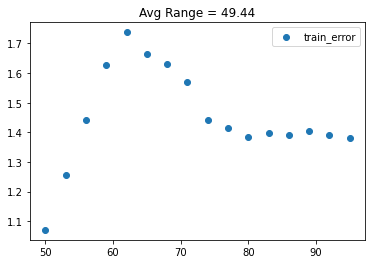

In [7]:
fig = plt.figure(facecolor=(1, 1, 1))
Range =df['high'][split:]-df['low'][split:]
plt.scatter(list(avg_train_err.keys()),list(avg_train_err.values()),label='train_error')
plt.legend(loc='best')
avgRange = np.average(Range)
plt.title(f'Avg Range = %1.2f'%avgRange)
print ('\nAverage Range of the data:',np.average(Range))
plt.savefig('../web/assets/lasso-error.png')


### I created a new Range value to hold the average daily trading range of the data. It is a metric that I would like to compare with when I am making a prediction. The logic behind this comparison is that if my prediction error is more than the day’s range then it is likely that it will not be useful.

### I might as well use the previous day’s High or Low as the prediction, which will turn out to be more accurate. Please note I have used the split value outside the loop. This implies that the average range of the day that you see here is relevant to the last iteration.
## What does this scatter plot tell you? Let me ask you a few questions.

* Is the equation over-fitting?
* The performance of the data improved remarkably as the train data set size increased. Does this mean if we give more data the error will reduce further?
* Is there an inherent trend in the market, allowing us to make better predictions as the data set size increases?
* Last but the best question How will we use these predictions to create a trading strategy?
### Q: Is the equation over-fitting?
### A: This was the first question I had asked. To know if your data is overfitting or not, the best way to test it would be to check the prediction error that the algorithm makes in the train and test data.
### To do this, we will have to add a small piece of code to the already written code.

In [ ]:
fig = plt.figure(facecolor=(1, 1, 1))

Range =df['high'][split:]-df['low'][split:]
# ------------------------------------------------------------------------ added code below.
plt.scatter(list(avg_err.keys()),list(avg_err.values()), label='test_error')
# ---------------------------------------------------------------------------
plt.scatter(list(avg_train_err.keys()),list(avg_train_err.values()),label='train_error')
plt.legend(loc='best')
avR = np.average(Range)
plt.title(f'Avg Range = %1.2f'%avR)
print ('\nAverage Range of the Day:',np.average(Range))
plt.savefig('../web/assets/train-test-error.png')



## If our algorithm is doing better in the test data compared to the train data, is this observation in itself a red flag.?There are a few reasons why our test data error could be better than the train data error:

## If the train data had greater volatility (Daily range) compared to the test set, then the prediction would also exhibit greater volatility.
### If there was an inherent trend in the market that helped the algo make better predictions.
### Now, let us check which of these cases is true. If the range of the test data was less than the train data, then the error should have decreased after passing more than 80% of the data as a train set, but it increases.

## Q: Can the machine learning algorithm detect the inherent trend or market phase (bull/bear/sideways/breakout/panic)?

## Q: Can the database be trimmed in a way to train different algos for different situations

## A: The answer to both the questions is YES!

### We can divide the market into different regimes and then use these signals to trim the data and train different algorithms for these datasets. To achieve this, I choose to use an unsupervised machine learning algorithm.

### From here on, this Python machine learning tutorial will be dedicated to creating an algorithm that can detect the inherent trend in the market without explicitly training for it.

In [ ]:
from pandas_datareader import data as web
from sklearn import mixture as mix
import seaborn as sns 
import matplotlib.pyplot as plt

In [ ]:
df=df[['open','high','low','close']]
df['open']=df['open'].shift(1)
df['high']=df['high'].shift(1)
df['low']=df['low'].shift(1)
df['close']=df['close'].shift(1)
df=df[['open','high','low','close']]
df=df.dropna()

# Instantiate an unsupervised machine learning algorithm using the ‘Gaussian mixture’ model from sklearn.

In [ ]:
unsup = mix.GaussianMixture(n_components=3, 
                            covariance_type="spherical", 
                            n_init=100, 
                            random_state=42)

In [ ]:
unsup.fit(np.reshape(df,(-1,df.shape[1])))
regime = unsup.predict(np.reshape(df,(-1,df.shape[1])))

# Now let us calculate the returns of the day.

In [ ]:
df['Return']= np.log(df['close']/df['close'].shift(1))

# Then, create a dataframe called Regimes which will have the OHLC and Return values along with the corresponding regime classification.

In [ ]:
Regimes=pd.DataFrame(regime,columns=['Regime'],index=df.index)\
                     .join(df, how='inner')\
                          .assign(market_cu_return=df.Return.cumsum())\
                                 .reset_index(drop=False)\
                                             .rename(columns={'index':'Date'})

## After this, let us create a list called ‘order’ that has the values corresponding to the regime classification, and then plot these values to see how well the algo has classified.

# The final regime differentiation would look like this:



In [ ]:
order=[0,1,2]
fig = sns.FacetGrid(data=Regimes,hue='Regime',hue_order=order,aspect=2,height= 4)
fig.map(plt.scatter,'Date','market_cu_return', s=4).add_legend(labelcolor='white')
plt.tick_params(colors='white', grid_color='black')
plt.rcParams['text.color']='w'

plt.grid()
plt.savefig('../web/assets/lasso.png', bbox_inches='tight')
plt.show()


### This graph looks pretty good to me. Without actually looking at the factors based on which the classification was done, we can conclude a few things just by looking at the chart.

1. The blue zone is the low volatility or the sideways zone
2. The orange zone is high volatility zone or panic zone.
3. The purple zone is a breakout up/down zone.
4. The red zone: high Mean, high covariance zone.
5. The purple zone mid mean low covariance i really have no clue besided looks toppy and rangey
* Use the code below to print the relevant data for each regime

In [ ]:
for i in order:
    print('Mean for regime %i: '%i,unsup.means_[i][0])
    print('Co-Variancefor regime %i: '%i,(unsup.covariances_[i]))
    
# The output would look like this:

### The data can be inferred as follows:
0. Regime 0: high mean and low covariance.
1. Regime 1: low mean and high covariance.  
2. Regime 2: mid range mean and low covariance.
3. Regime 3: high mean and low covariance.
4. Regime 4: mid mean low covariance.